In [ ]:
!pip install segmentation-models-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from PIL import UnidentifiedImageError
import cv2
import segmentation_models_pytorch as sm


In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Cup/cup_disc_segments.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: cup_labels/3762.txt     
  inflating: cup_labels/3763.txt     
  inflating: cup_labels/3764.txt     
  inflating: cup_labels/3766.txt     
  inflating: cup_labels/3767.txt     
  inflating: cup_labels/3769.txt     
  inflating: cup_labels/376L (C).txt  
  inflating: cup_labels/376R (C).txt  
  inflating: cup_labels/377.txt      
  inflating: cup_labels/3770.txt     
  inflating: cup_labels/3772.txt     
  inflating: cup_labels/3773.txt     
  inflating: cup_labels/3774.txt     
  inflating: cup_labels/3775.txt     
  inflating: cup_labels/3776.txt     
  inflating: cup_labels/3777.txt     
  inflating: cup_labels/3778.txt     
  inflating: cup_labels/3779.txt     
  inflating: cup_labels/377L (C).txt  
  inflating: cup_labels/377R (C).txt  
  inflating: cup_labels/378.txt      
  inflating: cup_labels/3781.txt     
  inflating: cup_labels/3782.txt     
  inflating: cup_labels/3784.txt     
  inflating: cup_labels/378

In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Image/all_images-001.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: all_images/1750.jpg     
  inflating: all_images/1751.jpg     
  inflating: all_images/1752.jpg     
  inflating: all_images/1753.jpg     
  inflating: all_images/1754.jpg     
  inflating: all_images/1755.jpg     
  inflating: all_images/1756.jpg     
  inflating: all_images/1757.jpg     
  inflating: all_images/1758.jpg     
  inflating: all_images/1759.jpg     
  inflating: all_images/175L (C).jpg  
  inflating: all_images/175R (C).jpg  
  inflating: all_images/176.jpg      
  inflating: all_images/1760.jpg     
  inflating: all_images/1761.jpg     
  inflating: all_images/1762.jpg     
  inflating: all_images/1763.jpg     
  inflating: all_images/1764.jpg     
  inflating: all_images/1765.jpg     
  inflating: all_images/1766.jpg     
  inflating: all_images/1767.jpg     
  inflating: all_images/1768.jpg     
  inflating: all_images/1769.jpg     
  inflating: all_images/176L (C).jpg  
  inflating: all_images/176R

In [ ]:
def create_mask_from_txt(txt_path, img_size, padding=10):
    with open(txt_path, 'r') as f:
        coords = list(map(float, f.read().split()))[1:]
    coords = np.array(coords).reshape(-1, 2)
    coords[:, 0] *= img_size[1]
    coords[:, 1] *= img_size[0]

    coords[:, 0] = np.clip(coords[:, 0] + padding, 0, img_size[1] - 1)
    coords[:, 1] = np.clip(coords[:, 1] + padding, 0, img_size[0] - 1)

    mask = np.zeros(img_size, dtype=np.uint8)

    cv2.fillPoly(mask, [coords.astype(int)], color=1)

    return mask


In [ ]:
mask_dir = '/content/disc_labels'
txt_files = os.listdir(mask_dir)
mask_save_dir = '/content/disc_mask'
os.makedirs(mask_save_dir, exist_ok=True)

for txt_file in txt_files:
    txt_path = os.path.join(mask_dir, txt_file)
    mask = create_mask_from_txt(txt_path, img_size=(512, 512))
    mask_path = os.path.join(mask_save_dir, txt_file.replace('.txt', '.png'))
    cv2.imwrite(mask_path, mask * 255)

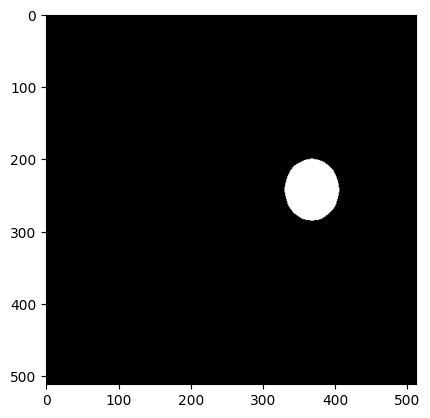

In [ ]:
mask_path = '/content/disc_mask/016R (2).png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
csv_file_path = '/content/drive/MyDrive/siriraj-eye-dataset/all_labels_processed.csv'
df = pd.read_csv(csv_file_path)

df = df.drop(columns=['camera','glaucoma_suspect','image_quality','image_quality_split', 'has_cup', 'has_disc', 'filename', 'has_cup_split','dr_label','dr_label_split'])

old_base_path = '../dataset/siriraj-eye-dataset-2023-jan/all_images'
new_base_path = '/content/all_images'
df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path).replace('\\', '/'))

In [ ]:
df.set_index('path', inplace=False)

,has_disc_split
path,
/content/all_images/0.jpg,NaN
/content/all_images/1.jpg,train
/content/all_images/2.jpg,train
/content/all_images/3.jpg,train
/content/all_images/4.jpg,train
...,...
/content/all_images/515L (C).jpg,NaN
/content/all_images/596L (c).jpg,train
/content/all_images/544L (C).jpg,train


In [ ]:
df = df.dropna(subset=['has_disc_split'])

In [ ]:
print(df)

                                  path has_disc_split
1            /content/all_images/1.jpg          train
2            /content/all_images/2.jpg          train
3            /content/all_images/3.jpg          train
4            /content/all_images/4.jpg          train
5            /content/all_images/5.jpg          train
...                                ...            ...
6161  /content/all_images/497R (C).jpg          train
6162  /content/all_images/293R (C).jpg          train
6164  /content/all_images/596L (c).jpg          train
6165  /content/all_images/544L (C).jpg          train
6166  /content/all_images/538L (C).jpg          train

[3410 rows x 2 columns]


In [ ]:
train_df = df[df['has_disc_split'] == 'train']
test_df = df[df['has_disc_split'] == 'test']
train_df, val_df = train_test_split(train_df, test_size=683/len(train_df), random_state=42)
train_df.drop(columns=['has_disc_split'], inplace=True)
val_df.drop(columns=['has_disc_split'], inplace=True)
test_df.drop(columns=['has_disc_split'], inplace=True)

<ipython-input-13-56cdd4de0053>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['has_disc_split'], inplace=True)


In [ ]:
print(val_df)

                                                   path
4136                       /content/all_images/4136.jpg
3705                       /content/all_images/3705.jpg
4770  /content/all_images/268d17a0424db0e06f1bed6262...
3505                       /content/all_images/3505.jpg
98                           /content/all_images/98.jpg
...                                                 ...
3374                       /content/all_images/3374.jpg
3729                       /content/all_images/3729.jpg
2970                       /content/all_images/2970.jpg
4848  /content/all_images/379e6e64a2126d9f53737f03f3...
3917                       /content/all_images/3917.jpg

[683 rows x 1 columns]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class EyeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:

train_images = train_df['path'].tolist()
train_masks = [path.replace('all_images', 'disc_mask').replace('.jpg', '.png') for path in train_images]

val_images = val_df['path'].tolist()
val_masks = [path.replace('all_images', 'disc_mask').replace('.jpg', '.png') for path in val_images]

test_images = test_df['path'].tolist()
test_masks = [path.replace('all_images', 'disc_mask').replace('.jpg', '.png') for path in test_images]



In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


train_dataset = EyeDataset(train_images, train_masks, transform=transform)
val_dataset = EyeDataset(val_images, val_masks, transform=transform)
test_dataset = EyeDataset(test_images, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
model = sm.Unet('resnet34', classes=2, activation=None)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.5MB/s]


In [ ]:
def iou_score(output, target):
    output = torch.argmax(output, dim=1)
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()
    iou = intersection / union
    return iou.item()

def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).long()
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_iou += iou_score(outputs, masks)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou = running_iou / len(loader.dataset)

    return epoch_loss, epoch_iou


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            masks = masks.squeeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou = running_iou / len(loader.dataset)

    return epoch_loss, epoch_iou


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
EPOCHS = 20

In [ ]:
best_loss = 10
best_model_path = '/content/drive/MyDrive/siriraj-eye-dataset/disc_model.pth'

for epoch in range(EPOCHS):
    train_loss, train_iou, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_loss:
        print(f'New best model found! Previous best loss: {best_loss:.4f}, new best loss: {val_loss:.4f}. Saving model...')
        torch.save(model.state_dict(), best_model_path)
        best_loss = val_loss


Epoch [1/20], Train Loss: 0.0027, Train IoU: 0.1139, Train Acc: 0.1251, Val Loss: 0.0030, Val IoU: 0.1135, Val Acc: 0.1258
New best model found! Previous best loss: 10.0000, new best loss: 0.0030. Saving model...
Epoch [2/20], Train Loss: 0.0026, Train IoU: 0.1143, Train Acc: 0.1251, Val Loss: 0.0029, Val IoU: 0.1140, Val Acc: 0.1258
New best model found! Previous best loss: 0.0030, new best loss: 0.0029. Saving model...
Epoch [3/20], Train Loss: 0.0025, Train IoU: 0.1149, Train Acc: 0.1251, Val Loss: 0.0030, Val IoU: 0.1134, Val Acc: 0.1258
Epoch [4/20], Train Loss: 0.0023, Train IoU: 0.1155, Train Acc: 0.1251, Val Loss: 0.0031, Val IoU: 0.1136, Val Acc: 0.1258
Epoch [5/20], Train Loss: 0.0023, Train IoU: 0.1156, Train Acc: 0.1251, Val Loss: 0.0032, Val IoU: 0.1133, Val Acc: 0.1258
Epoch [6/20], Train Loss: 0.0024, Train IoU: 0.1152, Train Acc: 0.1251, Val Loss: 0.0032, Val IoU: 0.1136, Val Acc: 0.1258
Epoch [7/20], Train Loss: 0.0026, Train IoU: 0.1149, Train Acc: 0.1251, Val Loss: 0

In [ ]:
weights = torch.load('/content/drive/MyDrive/siriraj-eye-dataset/disc_model.pth')

model.load_state_dict(weights)

<All keys matched successfully>

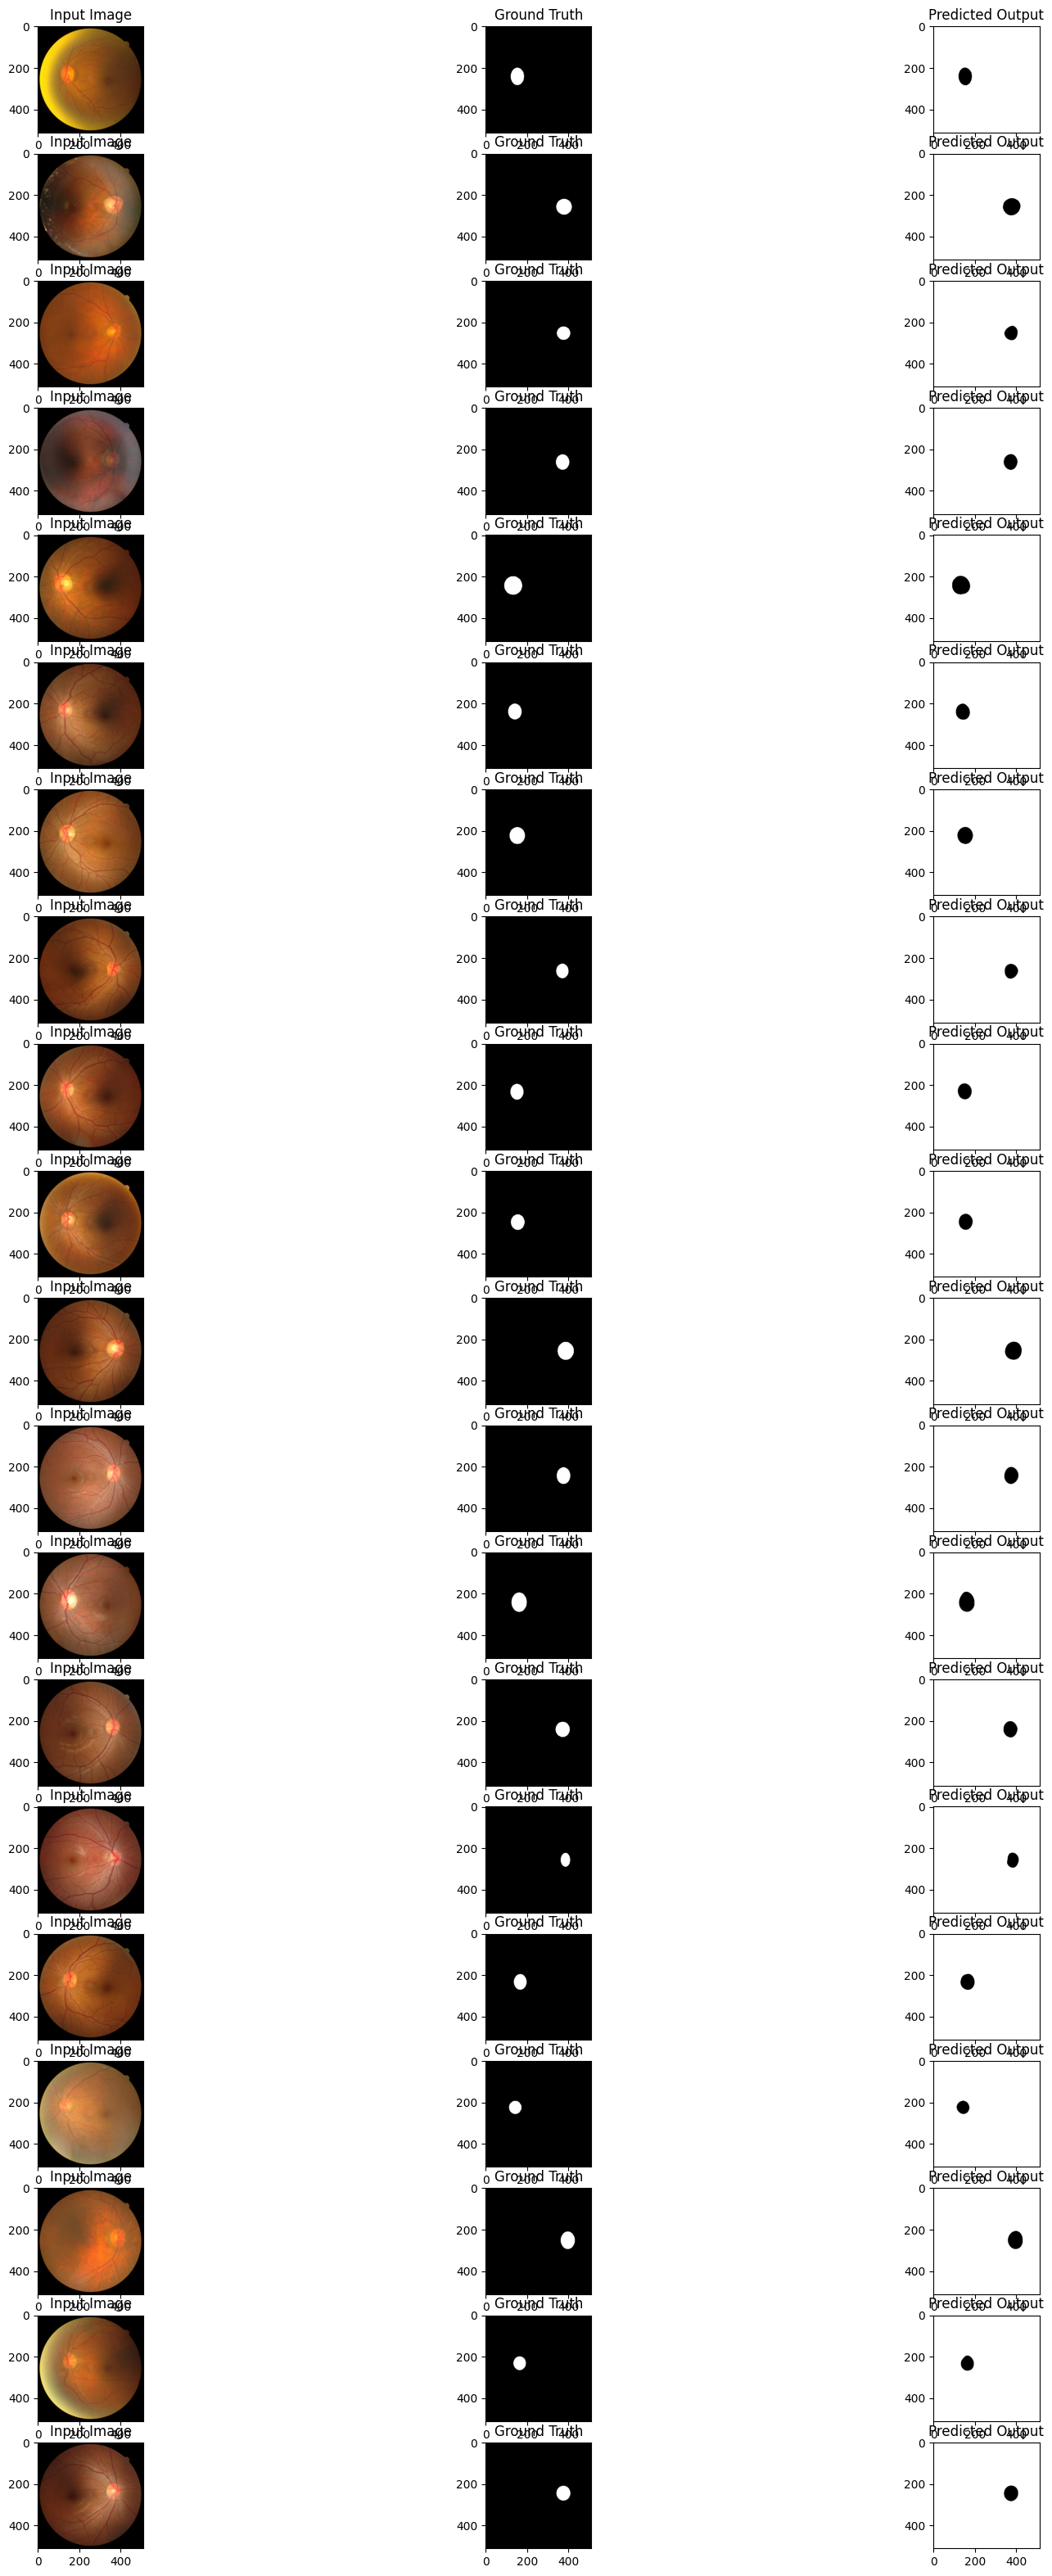

In [ ]:

model.eval()


fig = plt.figure(figsize=(20, 40))

num_images = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for j in range(inputs.size()[0]):
            num_images += 1

            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
            ax.title.set_text('Input Image')

            num_images += 1
            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(labels.cpu().data[j].numpy().squeeze(), cmap='gray')
            ax.title.set_text('Ground Truth')

            num_images += 1
            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(preds.cpu().data[j][0].numpy().squeeze(), cmap='gray')
            ax.title.set_text('Predicted Output')

            if num_images == 60:
                break

        if num_images == 60:
            break

plt.show()
